# SOMocluSummarizer+Quality Control demo

Author: Ziang Yan <br>
Last successfully run: Nov 22, 2024<br>

This notebook creats an end-to-end example for the SOM summarizer PLUS quality controld defined in https://arxiv.org/pdf/2007.15635. Including:

1) create photometric realizations for a training and spectroscopic sample;
2) measuring BPZ for the training and spectroscopic samples;
3) make the same tomographic cut on the training and spec samples;
4) informing a `rail_som` model with the training sample and summarizing it with the spec sample;
5) performing two quality control (arXiv: 1909.09632);
6) summarizing the goodness of redshift calibration and compare between QCs;


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import rail
import os
import qp
from rail.core.utils import RAILDIR

import tables_io
from rail.core.data import TableHandle, ModelHandle
from rail.core.stage import RailStage
from rail.estimation.algos.somoclu_som import SOMocluInformer, SOMocluSummarizer
from rail.estimation.algos.somoclu_som import get_bmus, plot_som

Next, let's set up the Data Store, so that our RAIL module will know where to fetch data:

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

First, let's grab some data files.  For the SOM, we will want to train on a fairly large, representative set that encompasses all of our expected data.  We'll grab a larger data file than we typically use in our demos to ensure that we construct a meaningful SOM.

## Run this command on the command line to get the larger data file to train the SOM:
`curl -O https://portal.nersc.gov/cfs/lsst/schmidt9/healpix_10326_bright_data.hdf5`

and then move the resulting file to this directory, i.e. RAIL/examples/estimation.  This data consists of ~150,000 galaxies from a single healpix pixel of the comsoDC2 truth catalog with mock 10-year magnitude errors added.  It is cut at a relatively bright i<23.5 magnitudes in order to concentrate on galaxies with particularly high S/N rates.

# First read the target and spec catalogue from a pre-trained pzflow stage.

In [3]:
training_file = "./healpix_10326_bright_data.hdf5"

if not os.path.exists(training_file):
  os.system('curl -O https://portal.nersc.gov/cfs/lsst/PZ/healpix_10326_bright_data.hdf5')


In [4]:
training_data = DS.read_file("training_data", TableHandle, training_file)

In [5]:
pmask = (training_data.data['photometry']['mag_i_lsst'] <23.5)
trim_test = {}
for key in training_data.data['photometry'].keys():
    trim_test[key] = training_data.data['photometry'][key][pmask]
trim_dict = dict(photometry=trim_test)
target_data_all = DS.add_data("target_data_raw", trim_dict, TableHandle)

In [6]:
from rail.utils.path_utils import find_rail_file

specfile = find_rail_file("examples_data/testdata/test_dc2_validation_9816.hdf5")
ref_data_raw = tables_io.read(specfile)['photometry']
smask = (ref_data_raw['mag_i_lsst'] <23.5)
trim_spec = {}
for key in ref_data_raw.keys():
    trim_spec[key] = ref_data_raw[key][smask]
trim_dict = dict(photometry=trim_spec)
ref_data_all = DS.add_data("ref_data_raw", trim_dict, TableHandle)

# Now measure the photometric redshifts using the `bpz_lite`

In [7]:
bands = ["u", "g", "r", "i", "z", "y"]
lsst_bands = []
lsst_errs = []
lsst_filts = []
for band in bands:
    lsst_bands.append(f"mag_{band}_lsst")
    lsst_errs.append(f"mag_err_{band}_lsst")
    lsst_filts.append(f"DC2LSST_{band}")
print(lsst_bands)
print(lsst_filts)

['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']
['DC2LSST_u', 'DC2LSST_g', 'DC2LSST_r', 'DC2LSST_i', 'DC2LSST_z', 'DC2LSST_y']


In [8]:
from rail.core.utils import RAILDIR
import os
from rail.core.utils import RAILDIR
from rail.estimation.algos.bpz_lite import BPZliteInformer, BPZliteEstimator
from rail.core.data import ModelHandle
custom_data_path = RAILDIR + '/rail/examples_data/estimation_data/data'

hdfnfile = os.path.join(RAILDIR, "rail/examples_data/estimation_data/data/CWW_HDFN_prior.pkl")
sedfile = os.path.join(RAILDIR, "rail/examples_data/estimation_data/data/SED/COSMOS_seds.list")

with open(hdfnfile, "rb") as f:
    hdfnmodel = pickle.load(f)

custom_dict_phot = dict(hdf5_groupname="photometry",
                   output="bpz_results_phot_qc.hdf5", 
                   bands=lsst_bands, 
                   err_bands=lsst_errs,
                   filter_list=lsst_filts,
                   prior_band='mag_i_lsst',spectra_file=sedfile,
                   data_path=custom_data_path,
                   no_prior=False)

custom_dict_spec = dict(hdf5_groupname="photometry",
                   output="bpz_results_spec_qc.hdf5", 
                    bands=lsst_bands, 
                   err_bands=lsst_errs,
                   filter_list=lsst_filts,
                   prior_band='mag_i_lsst',spectra_file=sedfile,
                   data_path=custom_data_path,
                   no_prior=False)

cosmospriorfile = os.path.join(RAILDIR, "rail/examples_data/estimation_data/data/COSMOS31_HDFN_prior.pkl")
cosmosprior = DS.read_file("cosmos_prior", ModelHandle, cosmospriorfile)

phot_run = BPZliteEstimator.make_stage(name="rerun_bpz_phot", model=cosmosprior, **custom_dict_phot)
spec_run = BPZliteEstimator.make_stage(name="rerun_bpz_spec", model=cosmosprior, **custom_dict_spec)

In [9]:
from collections import OrderedDict
phot_run.estimate(target_data_all)

Process 0 running estimator on chunk 0 - 150818


/net/home/fohlen14/yanza21/research/src/RAIL_new/rail_bpz/src/rail/estimation/algos/bpz_lite.py:478: RuntimeWarning: overflow encountered in cast
  flux_err[unobserved] = 1e108


Inserting handle into data store.  output_rerun_bpz_phot: inprogress_bpz_results_phot_qc.hdf5, rerun_bpz_phot


In [10]:
spec_run.estimate(ref_data_all)

Process 0 running estimator on chunk 0 - 5166
Inserting handle into data store.  output_rerun_bpz_spec: inprogress_bpz_results_spec_qc.hdf5, rerun_bpz_spec


In [11]:
phot_bpz_file = 'bpz_results_phot_qc.hdf5'
bpz_phot_all = tables_io.read(phot_bpz_file)['ancil']['zmode']

spec_bpz_file = 'bpz_results_spec_qc.hdf5'
bpz_spec_all = tables_io.read(spec_bpz_file)['ancil']['zmode']

Text(0, 0.5, '$Z_{\\mathrm{phot}}$')

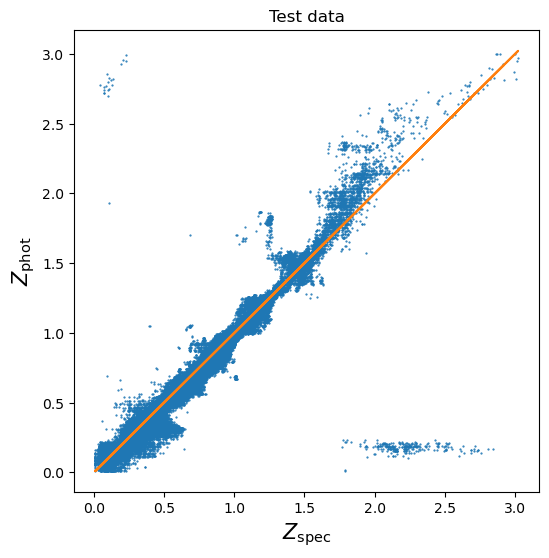

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(target_data_all.data['photometry']['redshift'], bpz_phot_all, s=0.3)
plt.plot(target_data_all.data['photometry']['redshift'],target_data_all.data['photometry']['redshift'], color='C1')
plt.title('Test data')
plt.xlabel(r'$Z_{\mathrm{spec}}$', fontsize=15)
plt.ylabel(r'$Z_{\mathrm{phot}}$', fontsize=15)

Text(0, 0.5, '$Z_{\\mathrm{phot}}$')

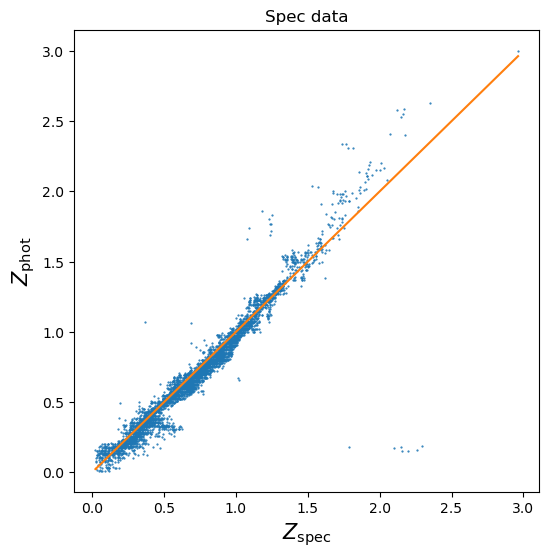

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(ref_data_all.data['photometry']['redshift'], bpz_spec_all, s=0.3)
plt.plot(ref_data_all.data['photometry']['redshift'],ref_data_all.data['photometry']['redshift'], color='C1')
plt.title('Spec data')
plt.xlabel(r'$Z_{\mathrm{spec}}$', fontsize=15)
plt.ylabel(r'$Z_{\mathrm{phot}}$', fontsize=15)

## cut the data to make a tomographic bin

In [14]:
bin_low = 0.2
bin_high = 0.5

In [15]:
trim_data_test = {}

mask_phot = ((bpz_phot_all > bin_low) & (bpz_phot_all < bin_high))
mask_phot &= (target_data_all.data['photometry']['redshift'] > 0)

bpz_phot = bpz_phot_all[mask_phot]

for key in target_data_all.data['photometry'].keys():
    trim_data_test[key] = target_data_all.data['photometry'][key][mask_phot]
trimdict_test = dict(photometry=trim_data_test)
target_data = DS.add_data("testing_data", trimdict_test, TableHandle)

In [16]:
trim_data_spec = {}

mask_spec = ((bpz_spec_all > bin_low) & (bpz_spec_all<bin_high))
mask_spec &= (ref_data_all.data['photometry']['redshift'] > 0)

bpz_spec = bpz_spec_all[mask_spec]

for key in target_data_all.data['photometry'].keys():
    trim_data_spec[key] = ref_data_all.data['photometry'][key][mask_spec]
trimdict_spec = dict(photometry=trim_data_spec)
ref_data = DS.add_data("ref_data", trimdict_spec, TableHandle)

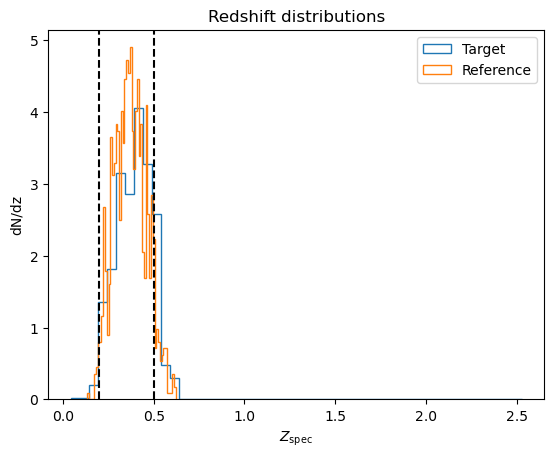

In [17]:
plt.title('Redshift distributions')
plt.xlabel(r'$Z_{\mathrm{spec}}$')
plt.ylabel('dN/dz')

plt.hist(target_data.data['photometry']['redshift'], bins=50, density=True, histtype='step', label='Target')
plt.hist(ref_data.data['photometry']['redshift'], bins=50, density=True, histtype='step', label='Reference')
plt.axvline(bin_low, color='k', linestyle='--')
plt.axvline(bin_high, color='k', linestyle='--')
plt.legend()

# Now let's train a SOM with the color from the target set

We need to define all of our necessary initialization params, which includes the following:<br>
`name` (str): the name of our estimator, as utilized by ceci<br>
`model` (str): the name for the model file containing the SOM and associated parameters that will be written by this stage<br>
`hdf5_groupname` (str): name of the hdf5 group (if any) where the photometric data resides in the training file<br>
`n_rows` (int): the number of dimensions in the y-direction for our 2D SOM<br>
`m_columns` (int): the number of dimensions in the x-direction for our 2D SOM<br>
`som_iterations` (int): the number of iteration steps during SOM training.  SOMs can take a while to converge, so we will use a fairly large number of 500,000 iterations.<br>
`std_coeff` (float): the "radius" of how far to spread changes in the SOM <br>
`som_learning_rate` (float): a number between 0 and 1 that controls how quickly the weighting function decreases.  SOM's are not guaranteed to converge mathematically, and so this parameter tunes how the response drops per iteration.  A typical values we might use might be between 0.5 and 0.75.<br>
`column_usage` (str):  this value determines what values will be used to construct the SOM, valid choices are `colors`, `magandcolors`, and `columns`.  If set to `colors`, the code will take adjacent columns as specified in `usecols` to construct colors and use those as SOM inputs.  If set to `magandcolors` it will use the single column specfied by `ref_column_name` and the aforementioned colors to construct the SOM.  If set to `columns` then it will simply take each of the columns in `usecols` with no modification.  So, if a user wants to use K magnitudes and L colors, they can precompute the colors and specify all names in `usecols`.  NOTE: accompanying `usecols` you must have a `nondetect_val` dictionary that lists the replacement values for any non-detection-valued entries for each column, see the code for an example dictionary.  WE will set `column_usage` to colors and use only colors in this example notebook.

In [18]:
dim = 101

grid_type = 'hexagonal'
inform_dict = dict(model='output_SOMoclu_model.pkl', hdf5_groupname='photometry',
                   n_rows=dim, n_columns=dim, 
                   gridtype = grid_type,
                   std_coeff=12.0, som_learning_rate=0.75,
                   column_usage='colors')

inform_som = SOMocluInformer.make_stage(name='inform_som', **inform_dict)

In [19]:
%%time
inform_som.inform(target_data)

Inserting handle into data store.  model_inform_som: inprogress_output_SOMoclu_model.pkl, inform_som
CPU times: user 4min 44s, sys: 1.07 s, total: 4min 45s
Wall time: 2.56 s


In [20]:
def get_cont_hist(data, bins):
    hist, bin_edge = np.histogram(data, bins=bins, density=True)
    return hist, (bin_edge[1:]+bin_edge[:-1])/2

# Summarize the SOM with target data and spectroscopic reference

In [21]:
from scipy.stats import norm

n_clusters = 1000

summ_dict = dict(model="output_SOMoclu_model.pkl", hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=25,
                 output='SOM_ensemble.hdf5', single_NZ='fiducial_SOMoclu_NZ.hdf5',
                 n_clusters=n_clusters,
                 uncovered_cluster_file ='all_uncovered_cells.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs.hdf5')

som_summarizer = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer', aliases=dict(model="model_somoclu__"), **summ_dict)
som_summarizer.summarize(target_data, ref_data)


Inserting handle into data store.  model_somoclu__: output_SOMoclu_model.pkl, SOMoclu_summarizer


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{1, 2, 4, 5, 6, 9, 11, 17, 18, 19, 24, 35, 37, 40, 47, 48, 49, 50, 52, 54, 56, 65, 67, 72, 73, 74, 75, 81, 86, 89, 92, 101, 104, 108, 116, 120, 123, 124, 125, 126, 128, 134, 135, 140, 142, 143, 144, 145, 149, 158, 162, 167, 169, 172, 176, 181, 183, 185, 187, 189, 190, 195, 199, 202, 203, 206, 210, 215, 218, 221, 222, 223, 225, 229, 230, 232, 233, 234, 238, 239, 241, 242, 243, 244, 246, 251, 259, 260, 261, 263, 264, 265, 267, 268, 269, 272, 273, 276, 277, 281, 282, 284, 287, 296, 301, 303, 304, 308, 309, 316, 317, 319, 332, 334, 335, 337, 339, 345, 346, 356, 358, 360, 365, 366, 367, 372, 373, 380, 383, 385, 386, 389, 391, 394, 396, 397, 398, 402, 403, 405, 406, 414, 422, 424, 425, 427, 428, 432, 434, 438, 442, 444, 448, 450, 455, 457, 458, 459, 46

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


We can calculate the best SOM cell using the get_bmus() function defined in somocluSOM.py, which will return the 2D SOM coordinates for each galaxy. Then we group the SOM cells into hierarchical clusters and calculate the occupation and mean redshift in each cluster. 

To do this, we first get the colors for the reference and target sample.

In [22]:
bands = ['u','g','r','i','z','y']
bandnames = [f"mag_{band}_lsst" for band in bands]

ngal_ref = len(ref_data.data['photometry']['mag_i_lsst'])
ngal_target = len(target_data.data['photometry']['mag_i_lsst'])

ref_colors = np.zeros([5, ngal_ref])
target_colors = np.zeros([5, ngal_target])
for i in range(5):

    ref_colors[i] = ref_data.data['photometry'][bandnames[i]] - ref_data.data['photometry'][bandnames[i+1]]
    target_colors[i] = target_data.data['photometry'][bandnames[i]] - target_data.data['photometry'][bandnames[i+1]]

In [23]:
with open("output_SOMoclu_model.pkl", "rb") as f:
    model = pickle.load(f)

Now we call the `get_bmus` function to get the best matching units for the reference and target data.

In [24]:
SOM = model['som']
ref_bmu_coordinates = get_bmus(SOM, ref_colors.T, 1000).T
target_bmu_coordinates = get_bmus(SOM, target_colors.T, 1000).T

Find the cluster index for each galaxy in the reference and target data

In [25]:
import sklearn.cluster as sc

algorithm = sc.AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
SOM.cluster(algorithm)
som_cluster_inds = SOM.clusters.reshape(-1)

ref_pixel_coords = np.ravel_multi_index(ref_bmu_coordinates, (dim, dim))
ref_som_clusterind = som_cluster_inds[ref_pixel_coords]

target_pixel_coords = np.ravel_multi_index(target_bmu_coordinates, (dim, dim))
target_som_clusterind = som_cluster_inds[target_pixel_coords]

The next cell defines some functions to plot cluster boundaries on a SOM grid. This function will be added to rail_som in a subsequent update. 

In [26]:
def plot_cluster_boundaries(ax, SOM, n_clusters, cluster_inds=None, topology='hexagonal'):
    dim = SOM.codebook.shape[0]
    som_cluster_ind = SOM.clusters.reshape(-1)
    som_centers = find_cell_centers(dim, topology=topology)
    som_centers_l = np.array([som_centers.T[0]-dim*1, som_centers.T[1]]).T
    som_centers_r = np.array([som_centers.T[0]+dim*1, som_centers.T[1]]).T
    som_centers_u = np.array([som_centers.T[0], som_centers.T[1]+dim*np.sqrt(3)/2]).T
    som_centers_b = np.array([som_centers.T[0], som_centers.T[1]-dim*np.sqrt(3)/2]).T
    if cluster_inds is None:
        cluster_inds = np.arange(n_clusters)
    for i in (cluster_inds):
        centers = (np.vstack([som_centers[np.where(som_cluster_ind==i)[0]],
                         som_centers_l[np.where(som_cluster_ind==i)[0]], som_centers_u[np.where(som_cluster_ind==i)[0]], 
                         som_centers_r[np.where(som_cluster_ind==i)[0]], som_centers_b[np.where(som_cluster_ind==i)[0]]]))
        linep = get_manycells_boundary(centers, topology='hexagonal')
        for points in linep:
            if points.T[0].min() < som_centers.T[0].min()-1 or points.T[0].max() > som_centers.T[0].max()+1 or points.T[1].min() < som_centers.T[1].min()-np.sqrt(3)/2 or points.T[1].max() > som_centers.T[1].max()+np.sqrt(3)/2:
            #plt.plot(points.T[0], points.T[1], color='blue')
                continue
            ax.plot(points.T[0], points.T[1], color='k', lw=0.2)
    return

def find_cell_centers(dim, topology='rectangular'):
    if topology == 'rectangular':
        x = np.arange(dim) + 0.5
        y = np.arange(dim) + 0.5
        xx, yy = np.meshgrid(x, y)
        xx = xx.reshape(-1)
        yy = yy.reshape(-1)
        centers = np.array([xx, yy]).T
    if topology == 'hexagonal':
        yy, xx= np.meshgrid(np.arange(dim), np.arange(dim))
        shift = np.zeros(dim)
        shift[::2]=-0.5
        xx = xx + shift
        yy = yy * (np.sqrt(3) / 2)
        centers = np.array([xx.reshape(-1), yy.reshape(-1)]).T
    return centers

def get_cell_boundary(center, topology='rectangular'):
    if topology == 'rectangular':
        points = [np.array([[center[0]-0.5, center[1]-0.5], [center[0]-0.5, center[1]+0.5]]),
                 np.array([[center[0]-0.5, center[1]+0.5], [center[0]+0.5, center[1]+0.5]]),
                np.array([[center[0]+0.5, center[1]-0.5], [center[0]+0.5, center[1]+0.5]]),
                 np.array([[center[0]-0.5, center[1]-0.5], [center[0]+0.5, center[1]-0.5]])]
        return points
    elif topology == 'hexagonal':
        dx = 0.5
        dy = np.sqrt(3)/6
        points = [np.array([[center[0]-dx, center[1]+dy], [center[0], center[1]+2*dy]]),
                  np.array([[center[0], center[1]+2*dy], [center[0]+dx, center[1]+dy]]),
                 np.array([[center[0]+dx, center[1]-dy], [center[0]+dx, center[1]+dy]]),
                 np.array([[center[0], center[1]-2*dy], [center[0]+dx, center[1]-dy]]),
                 np.array([[center[0]-dx, center[1]-dy], [center[0], center[1]-2*dy]]),
                 np.array([[center[0]-dx, center[1]-dy], [center[0]-dx, center[1]+dy]])]
    return points

def get_manycells_boundary(centers, topology='rectangular'):
    points=[]
    for center in centers:
        points+=get_cell_boundary(center, topology)
    points_unique, counts = np.unique(np.round(np.array(points),4), axis=0, return_counts=True)
    return points_unique[counts==1]


Now we calculate and plot the SOM grid color-coded by the average true redshift of the target sample (left panel) and the reference sample (right panel) to show the reference sample is indeed representing the redshift of the target galaxies

In [27]:
mean_photZ_ref = np.zeros_like(SOM.umatrix).reshape(-1)  # mean photometric redshift of reference data in each cell/cluster
mean_specZ_ref = np.zeros_like(SOM.umatrix).reshape(-1)  # mean spectroscopic redshift of reference data in each cell/cluster

mean_photZ_target = np.zeros_like(SOM.umatrix).reshape(-1)   # mean photometric redshift of target data in each cell/cluster
mean_specZ_target = np.zeros_like(SOM.umatrix).reshape(-1)   # mean spectroscopic redshift of target data in each cell/cluster

for i in range(n_clusters):
    
    mean_photZ_ref[som_cluster_inds==i] = np.median(bpz_spec[ref_som_clusterind==i])
    mean_specZ_ref[som_cluster_inds==i] = np.median(ref_data.data['photometry']['redshift'][ref_som_clusterind==i])
    
    mean_photZ_target[som_cluster_inds==i] = np.median(bpz_phot[target_som_clusterind==i])
    mean_specZ_target[som_cluster_inds==i] = np.median(target_data.data['photometry']['redshift'][target_som_clusterind==i])

/net/home/fohlen13/yanza21/anaconda3/envs/RAIL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/net/home/fohlen13/yanza21/anaconda3/envs/RAIL/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


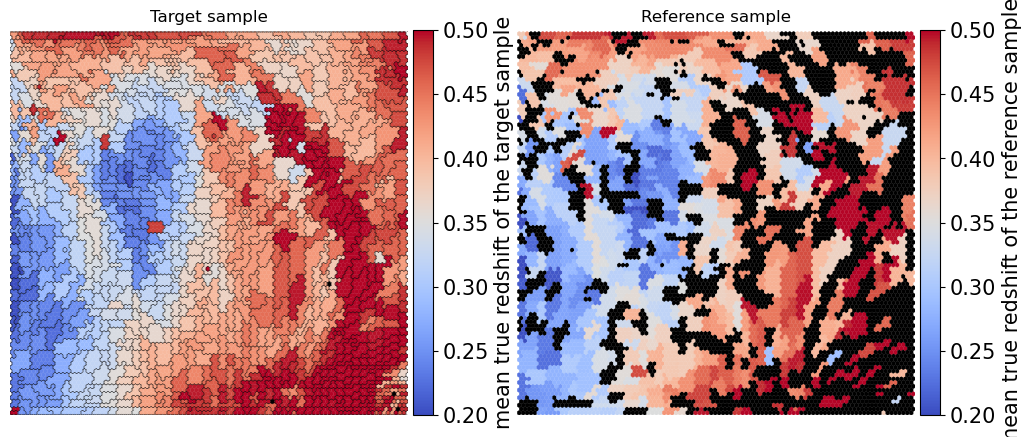

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_som(ax[0], mean_specZ_target.reshape(dim, dim), grid_type=grid_type, colormap=cm.coolwarm, cbar_name='mean true redshift of the target sample', vmin=bin_low, vmax=bin_high)
ax[0].set_title('Target sample')

plot_som(ax[1], mean_specZ_ref.reshape(dim, dim), grid_type=grid_type, colormap=cm.coolwarm, cbar_name='mean true redshift of the reference sample', vmin=bin_low, vmax=bin_high)

ax[1].set_title('Reference sample')
plot_cluster_boundaries(ax[0], SOM, n_clusters)

# Now let's do the quality control.

Quality control means selecting a subset of the clusters/SOM cells where the target galaxies are well represented by the reference sample.
We evaluate the "goodness-of-reference" by the two criteria given by https://arxiv.org/pdf/2007.15635 

Quality cut 1 (QC1):

$\frac{\left|\left\langle z_{\text {spec }}\right\rangle-\left\langle Z_{\mathrm{B}}\right\rangle\right|}{\operatorname{nMAD}\left(\left\langle z_{\text {spec }}\right\rangle-\left\langle Z_{\mathrm{B}}\right\rangle\right)}>5$

This QC will remove outliers in the distribution of photo-$z$.

Quality cut 2 (QC2):

$\left|\left\langle Z_B\right\rangle_{\text {spec }}-\left\langle Z_B\right\rangle_{\text {phot }}\right|>0.02$

This QC will remove clusters in which the target and reference sample have very different photo-$z$, which means the reference galaxies are not representative.

We also try to combine these two QCs.

In [29]:
from scipy.stats import median_abs_deviation

zmean_diff_cluster_qc1 = np.zeros(n_clusters)
zmean_diff_cluster_qccombined = np.zeros(n_clusters)

for i in range(n_clusters):   
    
    zmean_diff_cluster_qc1[i] = np.fabs(np.median(ref_data.data['photometry']['redshift'][ref_som_clusterind==i]) - np.median(bpz_phot[target_som_clusterind==i]))
        
    zmean_diff_cluster_qccombined[i] = np.fabs(np.median(bpz_phot[target_som_clusterind==i])-np.median(bpz_spec[ref_som_clusterind==i]))
    

cluster_ind_good = np.where(~np.isnan(zmean_diff_cluster_qccombined))
cluster_ind_good_qc1 = np.where(zmean_diff_cluster_qc1<max(median_abs_deviation((mean_specZ_ref-mean_photZ_ref)[~np.isnan(mean_specZ_ref-mean_photZ_ref)])*5, 0))
cluster_ind_good_qc2 = np.where(zmean_diff_cluster_qccombined<0.02)

cluster_ind_good_qccombined = np.intersect1d(cluster_ind_good_qc2, cluster_ind_good_qc1)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,12))
plot_som(ax, meanszs.reshape(dim, dim).T, grid_type=grid_type, colormap=cm.coolwarm, cbar_name='mean true redshift', vmin=bin_low, vmax=1)

Here is the cluster occupation distribution:

And here is the mean redshift per cluster:

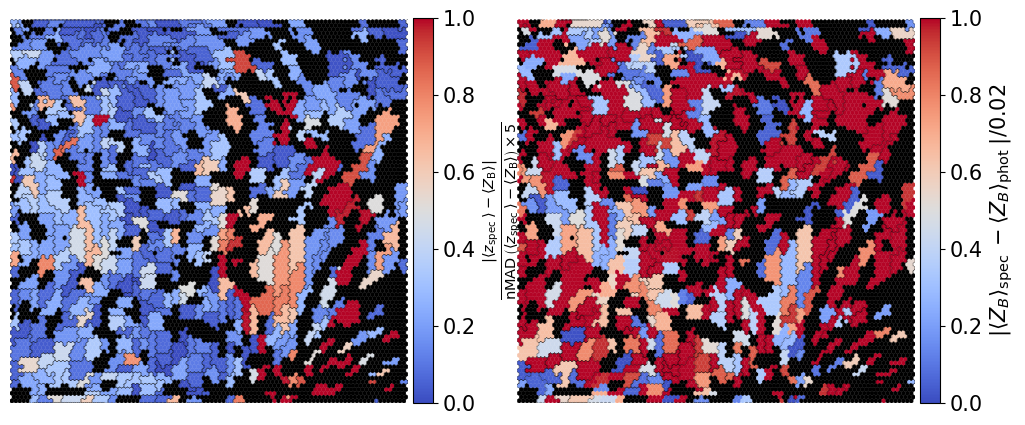

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

plot_som(ax[0], np.fabs(mean_specZ_ref-mean_photZ_target).reshape(dim,dim)/max(median_abs_deviation((mean_specZ_ref-mean_photZ_ref)[~np.isnan(mean_specZ_ref-mean_photZ_ref)])*5, 0), grid_type=grid_type, colormap=cm.coolwarm, cbar_name=r'$\frac{\left|\left\langle z_{\text {spec }}\right\rangle-\left\langle Z_{\mathrm{B}}\right\rangle\right|}{\operatorname{nMAD}\left(\left\langle z_{\text {spec }}\right\rangle-\left\langle Z_{\mathrm{B}}\right\rangle\right)\times 5}$', vmin=0, vmax=1)

plot_cluster_boundaries(ax[0], SOM, n_clusters, cluster_inds=cluster_ind_good_qc1[0])

zmean_diff = np.fabs(mean_specZ_target - mean_specZ_ref).reshape(dim, dim)

plot_som(ax[1], (zmean_diff)/0.02, grid_type=grid_type, colormap=cm.coolwarm, cbar_name=r'$\left|\left\langle Z_B\right\rangle_{\text {spec }}-\left\langle Z_B\right\rangle_{\text {phot }}\right|/0.02$', vmin=0, vmax=1)

plot_cluster_boundaries(ax[1], SOM, n_clusters, cluster_inds=cluster_ind_good_qc2[0])


Now that we have illustrated what exactly we have constructed, let's use the SOM to predict the redshift distribution for a set of photometric objects.  
We first summarize the case withouth QC, then the three QCs (QC1, QC2, QC1+QC2)

Note that we have removed the 'photometry' group, we will specify the `phot_groupname` as "" in the parameters below.<br>
As before, let us specify our initialization params for the SOMocluSummarizer stage, including:<br>
`model`: name of the pickled model that we created, in this case "output_SOM_model.pkl"<br>
`hdf5_groupname` (str): hdf5 group for our photometric data (in our case "")<br>
`objid_name` (str): string specifying the name of the ID column, if present photom data, will be written out to cellid_output file<br>
`spec_groupname` (str): hdf5 group for the spectroscopic data<br>
`nzbins` (int): number of bins to use in our histogram ensemble<br>
`n_clusters` (int): number of hierarchical clusters<br>
`nsamples` (int): number of bootstrap samples to generate<br>
`output` (str): name of the output qp file with N samples<br>
`single_NZ` (str): name of the qp file with fiducial distribution<br>
`uncovered_cell_file` (str): name of hdf5 file containing a list of all of the cells with phot data but no spec-z objects: photometric objects in these cells will *not* be accounted for in the final N(z), and should really be removed from the sample before running the summarizer.  Note that we return a single integer that is constructed from the pairs of SOM cell indices via `np.ravel_multi_index`(indices).<br>

Now let's initialize and run the summarizer.  One feature of the SOM: if any SOM cells contain photometric data but do not contain any redshifts values in the spectroscopic set, then no reasonable redshift estimate for those objects is defined, and they are skipped.  The method currently prints the indices of uncovered cells, we may modify the algorithm to actually output the uncovered galaxies in a separate file in the future.

Let's open the fiducial N(z) file, plot it, and see how it looks, and compare it to the true tomographic bin file:

In [31]:
boot_ens = qp.read('SOM_ensemble.hdf5')

target_nz_hist, zbin = get_cont_hist(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good)], np.linspace(0,3,101))

fid_ens = qp.read('fiducial_SOMoclu_NZ.hdf5')
som_nz_hist = np.squeeze(fid_ens.pdf(zbin))

full_ens = qp.read("SOM_ensemble.hdf5")
full_means = full_ens.mean().flatten()
full_stds = full_ens.std().flatten()
true_full_mean = np.mean(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good)])
true_full_std = np.std(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good)])
# mean and width of bootstraps
full_mu = np.mean(full_means)
full_sig = np.std(full_means)
full_norm = norm(loc=full_mu, scale=full_sig)
grid = np.linspace(0, .7, 301)
full_uncert = full_norm.pdf(grid)*2.51*full_sig

print('===========This is the fiducial case==================')

print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(full_means),4)) + '+-' + str(round(np.std(full_means),4)))
print("The mean redshift of the real data is: "+str(round(true_full_mean,4)))
print("The bias of mean redshift is:"+str(round(np.mean(full_means)-true_full_mean,4)) + '+-' + str(round(np.std(full_means),4)))

===========This is the fiducial case==================
The mean redshift of the SOM ensemble is: 0.3703+-0.0025
The mean redshift of the real data is: 0.3793
The bias of mean redshift is:-0.009+-0.0025


In [32]:
som_model_qc1=DS.read_file('som_model_qc1',  ModelHandle, "output_SOMoclu_model.pkl",)

summ_dict_qc1 = dict(model=som_model_qc1, hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=25,
                 output='SOM_ensemble_qc1.hdf5', single_NZ='fiducial_SOMoclu_NZ_qc1.hdf5',
                 n_clusters=n_clusters,
                 uncovered_cell_file='all_uncovered_cells_qc1.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs_qc1.hdf5', useful_clusters=cluster_ind_good_qc1[0])

som_summarizer_qc1 = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer_qc1', **summ_dict_qc1)
som_summarizer_qc1.summarize(target_data, ref_data)

fid_ens_qc1 = qp.read("fiducial_SOMoclu_NZ_qc1.hdf5")
boot_ens_qc1 = qp.read('SOM_ensemble_qc1.hdf5')
target_nz_hist_qc1, zbin_qc1 = get_cont_hist(target_data.data['photometry']['redshift'], np.linspace(0,3,101))
som_nz_hist_qc1 = np.squeeze(fid_ens_qc1.pdf(zbin))

target_nz_hist_qc1_true, zbin = get_cont_hist(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc1)], np.linspace(0,3,101))

full_ens_qc1 = qp.read("SOM_ensemble_qc1.hdf5")
full_means_qc1 = full_ens_qc1.mean().flatten()
full_stds_qc1 = full_ens_qc1.std().flatten()
true_full_mean_qc1 = np.mean(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc1)])
true_full_std_qc1 = np.std(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc1)])
# mean and width of bootstraps
full_mu_qc1 = np.mean(full_means_qc1)
full_sig_qc1 = np.std(full_means_qc1)
full_norm_qc1 = norm(loc=full_mu_qc1, scale=full_sig_qc1)
grid = np.linspace(0, .7, 301)
full_uncert_qc1 = full_norm_qc1.pdf(grid)*2.51*full_sig_qc1

print('\n\n===========This is the QC1 case==================')

print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(full_means_qc1),4)) + '+-' + str(round(np.std(full_means_qc1),4)))
print("The mean redshift of the real data is: "+str(round(true_full_mean_qc1,4)))
print("The bias of mean redshift is:"+str(round(np.mean(full_means_qc1)-true_full_mean_qc1,4)) + '+-' + str(round(np.std(full_means_qc1),4)))

Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer_qc1: inprogress_output_cellIDs_qc1.hdf5, SOMoclu_summarizer_qc1
the following clusters contain photometric data but not spectroscopic data:
{1, 2, 4, 5, 6, 9, 11, 17, 18, 19, 24, 35, 37, 40, 47, 48, 49, 50, 52, 54, 56, 65, 67, 72, 73, 74, 75, 81, 86, 89, 92, 101, 104, 108, 116, 120, 123, 124, 125, 126, 128, 134, 135, 140, 142, 143, 144, 145, 149, 158, 162, 167, 169, 172, 176, 181, 183, 185, 187, 189, 190, 195, 199, 202, 203, 206, 210, 215, 218, 221, 222, 223, 225, 229, 230, 232, 233, 234, 238, 239, 241, 242, 243, 244, 246, 251, 259, 260, 261, 263, 264, 265, 267, 268, 269, 272, 273, 276, 277, 281, 282, 284, 287, 296, 301, 303, 304, 308, 309, 316, 317, 319, 332, 334, 335, 337, 339, 345, 346, 356, 358, 360, 365, 366, 367, 372, 373, 380, 383, 385, 386, 389, 391, 394, 396, 397, 398, 402, 403, 405, 406, 414, 422, 424, 425, 427, 428, 432, 434, 438, 442, 444, 448, 450, 455, 457, 

NOTE/WARNING: Expected output file uncovered_cluster_file_SOMoclu_summarizer_qc1 was not generated.


In [33]:
from scipy.stats import norm

som_model_qc2=DS.read_file('som_model_qc2',  ModelHandle, "output_SOMoclu_model.pkl",)

summ_dict_qc2 = dict(model=som_model_qc2, hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=25,
                 output='SOM_ensemble_qc2.hdf5', single_NZ='fiducial_SOMoclu_NZ_qc2.hdf5',
                 n_clusters=n_clusters,
                 uncovered_cell_file='all_uncovered_cells_qc2.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs_qc2.hdf5', useful_clusters=cluster_ind_good_qc2[0])

som_summarizer_qc2 = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer_qc2', **summ_dict_qc2)
som_summarizer_qc2.summarize(target_data, ref_data)

fid_ens_qc2 = qp.read("fiducial_SOMoclu_NZ_qc2.hdf5")
boot_ens_qc2 = qp.read('SOM_ensemble_qc2.hdf5')
target_nz_hist_qc2, zbin_qc2 = get_cont_hist(target_data.data['photometry']['redshift'], np.linspace(0,3,101))
som_nz_hist_qc2 = np.squeeze(fid_ens_qc2.pdf(zbin))
target_nz_hist_qc2_true, zbin = get_cont_hist(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc2)], np.linspace(0,3,101))

full_ens_qc2 = qp.read("SOM_ensemble_qc2.hdf5")
full_means_qc2 = full_ens_qc2.mean().flatten()
full_stds_qc2 = full_ens_qc2.std().flatten()
true_full_mean_qc2 = np.mean(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc2)])
true_full_std_qc2 = np.std(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qc2)])
# mean and width of bootstraps
full_mu_qc2 = np.mean(full_means_qc2)
full_sig_qc2 = np.std(full_means_qc2)
full_norm_qc2 = norm(loc=full_mu_qc2, scale=full_sig_qc2)
grid = np.linspace(0, .7, 301)
full_uncert_qc2 = full_norm_qc2.pdf(grid)*2.51*full_sig_qc2

print("\n\n===========This is the QC2 case==================")

print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(full_means_qc2),4)) + '+-' + str(round(np.std(full_means_qc2),4)))
print("The mean redshift of the real data is: "+str(round(true_full_mean_qc2,4)))
print("The bias of mean redshift is:"+str(round(np.mean(full_means_qc2)-true_full_mean_qc2,4)) + '+-' + str(round(np.std(full_means_qc2),4)))

Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer_qc2: inprogress_output_cellIDs_qc2.hdf5, SOMoclu_summarizer_qc2
the following clusters contain photometric data but not spectroscopic data:
{1, 2, 4, 5, 6, 9, 11, 17, 18, 19, 24, 35, 37, 40, 47, 48, 49, 50, 52, 54, 56, 65, 67, 72, 73, 74, 75, 81, 86, 89, 92, 101, 104, 108, 116, 120, 123, 124, 125, 126, 128, 134, 135, 140, 142, 143, 144, 145, 149, 158, 162, 167, 169, 172, 176, 181, 183, 185, 187, 189, 190, 195, 199, 202, 203, 206, 210, 215, 218, 221, 222, 223, 225, 229, 230, 232, 233, 234, 238, 239, 241, 242, 243, 244, 246, 251, 259, 260, 261, 263, 264, 265, 267, 268, 269, 272, 273, 276, 277, 281, 282, 284, 287, 296, 301, 303, 304, 308, 309, 316, 317, 319, 332, 334, 335, 337, 339, 345, 346, 356, 358, 360, 365, 366, 367, 372, 373, 380, 383, 385, 386, 389, 391, 394, 396, 397, 398, 402, 403, 405, 406, 414, 422, 424, 425, 427, 428, 432, 434, 438, 442, 444, 448, 450, 455, 457, 

NOTE/WARNING: Expected output file uncovered_cluster_file_SOMoclu_summarizer_qc2 was not generated.


In [34]:
som_model_qccombined=DS.read_file('som_model_qccombined',  ModelHandle, "output_SOMoclu_model.pkl",)

summ_dict_qccombined = dict(model=som_model_qccombined, hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=25,
                 output='SOM_ensemble_qccombined.hdf5', single_NZ='fiducial_SOMoclu_NZ_qccombined.hdf5',
                 n_clusters=n_clusters,
                 uncovered_cell_file='all_uncovered_cells_qccombined.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs_qccombined.hdf5', useful_clusters=cluster_ind_good_qccombined)

som_summarizer_qccombined = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer_qccombined', **summ_dict_qccombined)
som_summarizer_qccombined.summarize(target_data, ref_data)

fid_ens_qccombined = qp.read("fiducial_SOMoclu_NZ_qccombined.hdf5")
boot_ens_qccombined = qp.read('SOM_ensemble_qccombined.hdf5')
target_nz_hist_qccombined, zbin_qccombined = get_cont_hist(target_data.data['photometry']['redshift'], np.linspace(0,3,101))
som_nz_hist_qccombined = np.squeeze(fid_ens_qccombined.pdf(zbin))
target_nz_hist_qccombined_true, zbin = get_cont_hist(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qccombined)], np.linspace(0,3,101))

full_ens_qccombined = qp.read("SOM_ensemble_qccombined.hdf5")
full_means_qccombined = full_ens_qccombined.mean().flatten()
full_stds_qccombined = full_ens_qccombined.std().flatten()
true_full_mean_qccombined = np.mean(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qccombined)])
true_full_std_qccombined = np.std(target_data.data['photometry']['redshift'][np.in1d(target_som_clusterind, cluster_ind_good_qccombined)])
# mean and width of bootstraps
full_mu_qccombined = np.mean(full_means_qccombined)
full_sig_qccombined = np.std(full_means_qccombined)
full_norm_qccombined = norm(loc=full_mu_qccombined, scale=full_sig_qccombined)
grid = np.linspace(0, .7, 301)
full_uncert_qccombined = full_norm_qccombined.pdf(grid)*2.51*full_sig_qccombined

print("\n\n===========This is the QC1+QC2 case==================")

print("The mean redshift of the SOM ensemble is: "+str(round(np.mean(full_means_qccombined),4)) + '+-' + str(round(np.std(full_means_qccombined),4)))
print("The mean redshift of the real data is: "+str(round(true_full_mean_qccombined,4)))
print("The bias of mean redshift is:"+str(round(np.mean(full_means_qccombined)-true_full_mean_qccombined,4)) + '+-' + str(round(np.std(full_means_qccombined),4)))

Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer_qccombined: inprogress_output_cellIDs_qccombined.hdf5, SOMoclu_summarizer_qccombined
the following clusters contain photometric data but not spectroscopic data:
{1, 2, 4, 5, 6, 9, 11, 17, 18, 19, 24, 35, 37, 40, 47, 48, 49, 50, 52, 54, 56, 65, 67, 72, 73, 74, 75, 81, 86, 89, 92, 101, 104, 108, 116, 120, 123, 124, 125, 126, 128, 134, 135, 140, 142, 143, 144, 145, 149, 158, 162, 167, 169, 172, 176, 181, 183, 185, 187, 189, 190, 195, 199, 202, 203, 206, 210, 215, 218, 221, 222, 223, 225, 229, 230, 232, 233, 234, 238, 239, 241, 242, 243, 244, 246, 251, 259, 260, 261, 263, 264, 265, 267, 268, 269, 272, 273, 276, 277, 281, 282, 284, 287, 296, 301, 303, 304, 308, 309, 316, 317, 319, 332, 334, 335, 337, 339, 345, 346, 356, 358, 360, 365, 366, 367, 372, 373, 380, 383, 385, 386, 389, 391, 394, 396, 397, 398, 402, 403, 405, 406, 414, 422, 424, 425, 427, 428, 432, 434, 438, 442, 444,

NOTE/WARNING: Expected output file uncovered_cluster_file_SOMoclu_summarizer_qccombined was not generated.


Now we plot the true/calibrated redshift distributions of the four cases

(0.0, 1.5)

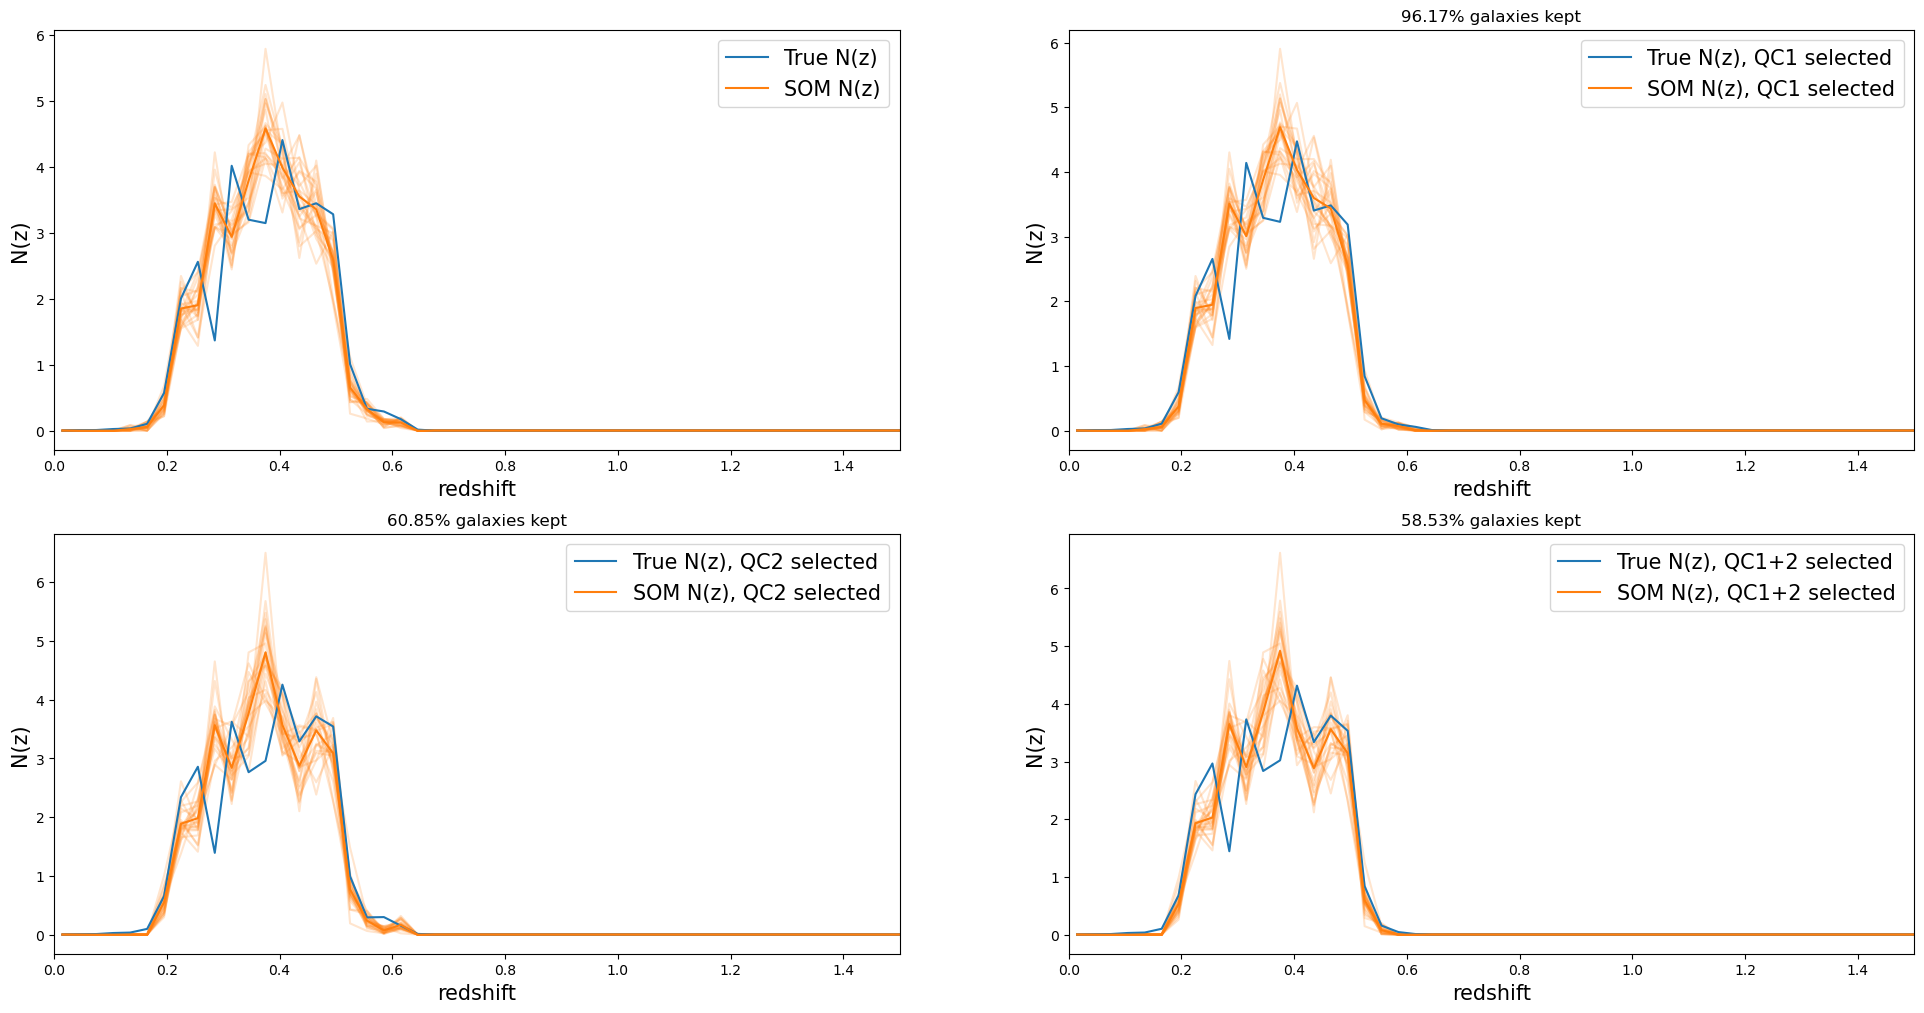

In [35]:
fig, ax = plt.subplots(2,2, figsize=(24,12))
ax = ax.flatten()
ax[0].set_xlabel("redshift", fontsize=15)
ax[0].set_ylabel("N(z)", fontsize=15)
ax[0].plot(zbin, target_nz_hist, label='True N(z)')
ax[0].plot(zbin, som_nz_hist,  color='C1',label='SOM N(z)')

for i in range(boot_ens.npdf):
    #ax = plt.subplot(2,3,i+1)
    pdf = np.squeeze(boot_ens[i].pdf(zbin))
    if i == 0:        
        ax[0].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)
    else:
        ax[0].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)

ax[1].set_title(f'{round(som_summarizer_qc1.neff_p_to_neff / som_summarizer.neff_p_to_neff*100, 2)}% galaxies kept')
ax[1].plot(zbin_qc1, target_nz_hist_qc1_true, color='C0',label='True N(z), QC1 selected')
ax[1].plot(zbin_qc1, som_nz_hist_qc1, color='C1',label='SOM N(z), QC1 selected')
ax[1].set_xlabel("redshift", fontsize=15)
ax[1].set_ylabel("N(z)", fontsize=15)
for i in range(boot_ens.npdf):
    #ax = plt.subplot(2,3,i+1)
    pdf = np.squeeze(boot_ens_qc1[i].pdf(zbin))
    if i == 0:        
        ax[1].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)
    else:
        ax[1].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)

ax[2].set_title(f'{round(som_summarizer_qc2.neff_p_to_neff / som_summarizer.neff_p_to_neff*100, 2)}% galaxies kept')
ax[2].plot(zbin_qc2, target_nz_hist_qc2_true, color='C0',label='True N(z), QC2 selected')
ax[2].plot(zbin_qc2, som_nz_hist_qc2, color='C1',label='SOM N(z), QC2 selected')
ax[2].set_xlabel("redshift", fontsize=15)
ax[2].set_ylabel("N(z)", fontsize=15)
for i in range(boot_ens.npdf):
    #ax = plt.subplot(2,3,i+1)
    pdf = np.squeeze(boot_ens_qc2[i].pdf(zbin))
    if i == 0:        
        ax[2].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)
    else:
        ax[2].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)

ax[3].set_title(f'{round(som_summarizer_qccombined.neff_p_to_neff / som_summarizer.neff_p_to_neff*100, 2)}% galaxies kept')
ax[3].plot(zbin_qccombined, target_nz_hist_qccombined_true, color='C0',label='True N(z), QC1+2 selected')
ax[3].plot(zbin_qccombined, som_nz_hist_qccombined, color='C1',label='SOM N(z), QC1+2 selected')
ax[3].set_xlabel("redshift", fontsize=15)
ax[3].set_ylabel("N(z)", fontsize=15)
for i in range(boot_ens.npdf):
    #ax = plt.subplot(2,3,i+1)
    pdf = np.squeeze(boot_ens_qccombined[i].pdf(zbin))
    if i == 0:        
        ax[3].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)
    else:
        ax[3].plot(zbin, pdf, color='C1',zorder=0, alpha=0.2)

ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
ax[3].legend(fontsize=15)
ax[0].set_xlim(0,1.5)
ax[1].set_xlim(0,1.5)
ax[2].set_xlim(0,1.5)
ax[3].set_xlim(0,1.5)

The following box plot summarizes the bias in the redshift estimation for the four cases

[Text(0, 1, 'SOM N(z), QC1+QC2'),
 Text(0, 2, 'SOM N(z), QC2'),
 Text(0, 3, 'SOM N(z), QC1'),
 Text(0, 4, 'SOM N(z)')]

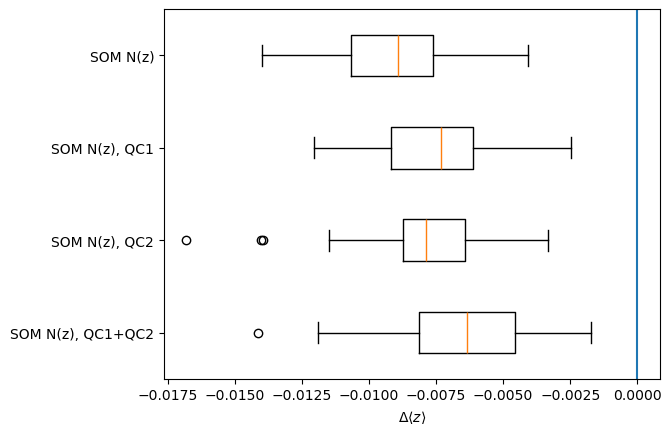

In [36]:
data = [full_means_qccombined-true_full_mean_qccombined, full_means_qc2-true_full_mean_qc2, full_means_qc1-true_full_mean_qc1, full_means-true_full_mean]

#plt.boxplot(data)
fig, ax = plt.subplots(1,1)
ax.boxplot(data, vert = 0)
ax.axvline(0,1,0, color='C0')
ax.set_xlabel(r'$\Delta\left\langle z \right\rangle$')
ax.set_yticklabels(['SOM N(z), QC1+QC2', 'SOM N(z), QC2','SOM N(z), QC1', 'SOM N(z)'])

In [37]:
import sys
#sys.path.append('/net/home/fohlen14/yanza21/research/src/RAIL_branches/RAIL/src/rail/estimation')

#from algos.somocluSOM import SOMocluSummarizer

n_clusterss = np.linspace(50, 1500, 10, dtype=int)

true_full_mean = np.mean(target_data.data['photometry']['redshift'])
true_full_std = np.std(target_data.data['photometry']['redshift'])
mu_diff = np.zeros(n_clusterss.size)
means_diff = np.zeros((n_clusterss.size, 50))

std_diff_mean = np.zeros(n_clusterss.size)
neff_p_to_neff = np.zeros(n_clusterss.size)
#neff_p_to_neff = np.zeros((n_clusterss.size, 25))
std_diff = np.zeros((n_clusterss.size, 50))
for i, n_clusters_ in enumerate(n_clusterss):
    summ_dict = dict(model="output_SOMoclu_model.pkl", hdf5_groupname='photometry',
                 spec_groupname='photometry', nzbins=101, nsamples=50,
                 output='SOM_ensemble.hdf5', single_NZ='fiducial_SOMoclu_NZ.hdf5',
                 n_clusters=n_clusters_,
                 uncovered_cluster_file ='all_uncovered_cells.hdf5',
                 objid_name='id',
                 cellid_output='output_cellIDs.hdf5')
    som_summarizer = SOMocluSummarizer.make_stage(name='SOMoclu_summarizer', aliases=dict(model="model_somoclu"), **summ_dict)    
    som_summarizer.summarize(target_data, ref_data)
    
    full_ens = qp.read("SOM_ensemble.hdf5")
    full_means = full_ens.mean().flatten()
    full_stds = full_ens.std().flatten()
    
    # mean and width of bootstraps
    mu_diff[i] = np.mean(full_means) - true_full_mean
    means_diff[i] = full_means - true_full_mean
    
    std_diff_mean[i] = np.mean(full_stds) - true_full_std
    std_diff[i] = full_stds - true_full_std
    neff_p_to_neff[i] = som_summarizer.neff_p_to_neff
    #neff_p_to_neff_mean[i] = np.mean(som_summarizer.neff_p_to_neff)
    full_sig = np.std(full_means)
    


Inserting handle into data store.  model_somoclu: output_SOMoclu_model.pkl, SOMoclu_summarizer


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{1, 34, 35, 39, 42, 24, 27}
43 out of 50 have usable data
Inserting handle into data store.  output_SOMoclu_summarizer: inprogress_SOM_ensemble.hdf5, SOMoclu_summarizer
Inserting handle into data store.  single_NZ_SOMoclu_summarizer: inprogress_fiducial_SOMoclu_NZ.hdf5, SOMoclu_summarizer
Inserting handle into data store.  uncovered_cluster_file_SOMoclu_summarizer: inprogress_all_uncovered_cells.hdf5, SOMoclu_summarizer


NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{129, 130, 135, 8, 141, 142, 143, 22, 29, 30, 158, 160, 163, 165, 166, 168, 177, 179, 180, 53, 187, 190, 203, 204, 77, 80, 208, 85, 95, 111, 114, 115, 121, 124, 127}
175 out of 211 have usable data
Inserting handle into data store.  output_SOMoclu_summarizer: inprogress_SOM_ensemble.hdf5, SOMoclu_summarizer
Inserting handle into data store.  single_NZ_SOMoclu_summarizer: inprogress_fiducial_SOMoclu_NZ.hdf5, SOMoclu_summarizer
Inserting handle into data store.  uncovered_cluster_file_SOMoclu_summarizer: inprogress_all_uncovered_cells.hdf5, SOMoclu_summarizer


NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{0, 2, 4, 10, 15, 18, 27, 44, 46, 55, 59, 61, 72, 82, 86, 92, 99, 109, 111, 125, 158, 159, 160, 163, 164, 165, 168, 171, 174, 177, 179, 180, 183, 187, 190, 192, 196, 200, 203, 204, 208, 209, 213, 222, 224, 226, 229, 232, 239, 240, 242, 243, 244, 246, 251, 252, 256, 258, 259, 261, 268, 269, 271, 273, 274, 277, 284, 285, 287, 299, 301, 302, 303, 315, 327, 330, 331, 333, 334, 343, 345, 346, 352, 356, 358, 360, 361, 365, 366}
282 out of 372 have usable data
Inserting handle into data store.  output_SOMoclu_summarizer: inprogress_SOM_ensemble.hdf5, SOMoclu_summarizer
Inserting handle into data store.  single_NZ_SOMoclu_summarizer: inprogress_fiducial_SOMoclu_NZ.hdf5, SOMoclu_summarizer
Inserting handle into data store.  uncovered_cluster_file_SOMoclu_

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{513, 515, 4, 516, 518, 8, 520, 522, 12, 524, 14, 527, 529, 18, 530, 531, 532, 30, 40, 43, 47, 52, 54, 59, 64, 85, 86, 88, 91, 93, 106, 109, 111, 119, 121, 125, 126, 141, 150, 159, 164, 165, 166, 174, 175, 176, 180, 189, 191, 196, 203, 207, 209, 211, 226, 227, 229, 232, 236, 237, 242, 252, 258, 260, 265, 266, 268, 269, 271, 273, 274, 277, 285, 287, 302, 303, 304, 315, 316, 327, 330, 331, 333, 341, 343, 345, 346, 356, 359, 360, 361, 363, 365, 366, 371, 372, 373, 375, 378, 380, 381, 385, 390, 392, 394, 395, 396, 398, 402, 404, 405, 406, 407, 408, 409, 411, 417, 418, 419, 421, 422, 424, 426, 429, 438, 442, 445, 446, 448, 449, 450, 457, 458, 459, 467, 469, 470, 471, 476, 477, 478, 485, 486, 487, 490, 493, 494, 496, 499, 503, 505, 508, 509, 510}
378 o

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{513, 2, 515, 4, 5, 516, 518, 520, 522, 524, 525, 527, 529, 530, 19, 20, 531, 532, 533, 534, 536, 538, 539, 540, 29, 30, 543, 33, 34, 546, 547, 550, 43, 555, 559, 565, 566, 570, 573, 62, 574, 575, 576, 577, 580, 582, 74, 75, 588, 590, 591, 592, 593, 594, 85, 599, 600, 89, 601, 603, 604, 93, 605, 607, 608, 609, 610, 614, 106, 618, 620, 111, 112, 623, 114, 625, 628, 119, 123, 639, 129, 641, 642, 644, 134, 135, 646, 648, 649, 650, 140, 651, 143, 144, 655, 656, 147, 657, 658, 661, 151, 152, 664, 665, 666, 157, 669, 670, 673, 163, 675, 676, 166, 679, 681, 171, 683, 686, 689, 691, 693, 182, 186, 189, 196, 197, 200, 202, 203, 205, 207, 208, 209, 211, 217, 222, 223, 227, 232, 234, 236, 237, 238, 242, 243, 246, 252, 254, 258, 265, 266, 267, 269, 271, 272,

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{1, 8, 11, 18, 21, 27, 31, 32, 37, 40, 42, 50, 58, 59, 62, 63, 64, 74, 75, 89, 98, 99, 100, 101, 103, 106, 110, 114, 118, 120, 121, 123, 124, 126, 128, 132, 134, 135, 138, 140, 144, 145, 151, 152, 155, 163, 164, 166, 169, 171, 172, 176, 179, 185, 186, 189, 192, 195, 201, 202, 203, 204, 206, 207, 209, 210, 211, 217, 222, 223, 225, 230, 233, 234, 243, 246, 250, 265, 266, 268, 269, 271, 272, 273, 281, 282, 284, 287, 288, 294, 296, 297, 298, 299, 301, 303, 305, 308, 317, 319, 325, 328, 332, 336, 337, 339, 345, 346, 348, 356, 358, 363, 365, 367, 372, 373, 375, 380, 382, 383, 391, 394, 397, 398, 400, 402, 405, 406, 407, 414, 422, 424, 438, 439, 442, 444, 448, 449, 450, 456, 457, 458, 459, 460, 462, 463, 465, 466, 467, 469, 470, 471, 475, 476, 477, 479,

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{3, 5, 8, 12, 17, 23, 35, 37, 40, 42, 45, 47, 50, 54, 55, 56, 59, 65, 67, 70, 72, 73, 74, 79, 81, 89, 97, 100, 101, 104, 108, 116, 120, 121, 123, 124, 125, 126, 128, 134, 135, 140, 141, 143, 144, 145, 149, 158, 162, 167, 169, 172, 174, 176, 181, 183, 185, 187, 189, 190, 195, 199, 200, 202, 203, 206, 210, 215, 218, 221, 222, 223, 225, 229, 230, 232, 233, 234, 238, 239, 241, 244, 246, 251, 259, 260, 261, 263, 264, 265, 267, 268, 269, 272, 273, 276, 277, 281, 282, 286, 287, 296, 301, 303, 304, 306, 308, 309, 316, 317, 319, 332, 334, 335, 337, 339, 345, 346, 356, 358, 360, 365, 366, 367, 372, 373, 380, 383, 385, 386, 389, 394, 396, 397, 398, 403, 405, 414, 422, 424, 425, 427, 428, 430, 432, 434, 438, 442, 444, 450, 455, 457, 458, 459, 460, 462, 463, 

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{2, 3, 6, 10, 13, 15, 17, 20, 24, 27, 30, 35, 36, 37, 39, 41, 44, 49, 51, 57, 60, 67, 71, 72, 75, 78, 80, 85, 87, 88, 96, 97, 99, 102, 105, 116, 117, 118, 120, 121, 122, 130, 132, 139, 140, 146, 149, 151, 152, 155, 157, 165, 169, 172, 174, 177, 183, 185, 188, 189, 190, 196, 197, 198, 202, 203, 210, 214, 215, 218, 221, 224, 228, 229, 230, 231, 232, 233, 234, 236, 239, 240, 241, 251, 255, 258, 263, 264, 265, 267, 268, 273, 276, 277, 278, 286, 287, 288, 293, 296, 299, 301, 303, 304, 309, 310, 311, 313, 316, 317, 319, 322, 327, 332, 334, 335, 337, 339, 344, 346, 356, 360, 364, 365, 366, 367, 370, 372, 373, 375, 378, 380, 383, 385, 386, 389, 391, 394, 395, 396, 397, 401, 403, 410, 414, 416, 418, 419, 420, 422, 427, 429, 430, 432, 434, 435, 441, 442, 4

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{2, 3, 4, 5, 6, 11, 13, 18, 19, 22, 34, 36, 37, 40, 43, 45, 46, 48, 51, 52, 53, 56, 57, 58, 59, 64, 65, 69, 72, 74, 75, 81, 82, 91, 98, 100, 104, 108, 113, 114, 115, 116, 118, 127, 131, 136, 137, 138, 144, 145, 150, 151, 154, 155, 156, 167, 169, 172, 174, 179, 181, 182, 185, 188, 190, 191, 194, 196, 197, 200, 202, 207, 209, 210, 214, 215, 217, 221, 222, 224, 227, 230, 234, 235, 236, 237, 240, 241, 242, 244, 245, 246, 250, 251, 254, 257, 258, 261, 262, 264, 265, 266, 267, 268, 269, 272, 274, 277, 278, 279, 284, 286, 287, 288, 289, 293, 296, 299, 301, 303, 304, 307, 308, 310, 313, 316, 319, 322, 323, 324, 325, 327, 328, 334, 337, 340, 343, 344, 346, 348, 355, 356, 361, 364, 365, 366, 370, 373, 374, 375, 376, 378, 379, 380, 381, 385, 386, 391, 394, 

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Process 0 running summarizer on chunk 0 - 30141
Inserting handle into data store.  cellid_output_SOMoclu_summarizer: inprogress_output_cellIDs.hdf5, SOMoclu_summarizer
the following clusters contain photometric data but not spectroscopic data:
{1, 6, 7, 12, 14, 16, 18, 28, 31, 32, 33, 36, 38, 42, 45, 47, 48, 50, 51, 54, 56, 57, 58, 65, 67, 70, 71, 72, 73, 74, 75, 76, 81, 83, 84, 85, 89, 90, 94, 98, 100, 101, 102, 108, 111, 114, 119, 120, 122, 123, 124, 128, 130, 131, 134, 136, 138, 141, 144, 145, 148, 151, 154, 156, 160, 161, 166, 169, 173, 175, 177, 178, 181, 182, 183, 184, 185, 186, 187, 189, 190, 192, 194, 196, 197, 198, 202, 204, 205, 206, 207, 209, 210, 213, 215, 216, 217, 219, 220, 224, 227, 228, 231, 233, 235, 236, 237, 238, 242, 243, 244, 245, 246, 249, 250, 254, 257, 258, 262, 264, 265, 266, 267, 268, 269, 271, 272, 275, 276, 277, 278, 279, 282, 284, 286, 287, 289, 293, 295, 299, 300, 301, 303, 304, 308, 310, 312, 315, 319, 322, 323, 324, 325, 328, 333, 334, 337, 343, 344, 349

NOTE/WARNING: Expected output file all_uncovered_cells.hdf5 was not generated.


Text(0, 0.5, "$n_{\\mathrm{eff}}\\'/n_{\\mathrm{eff}}$(%)")

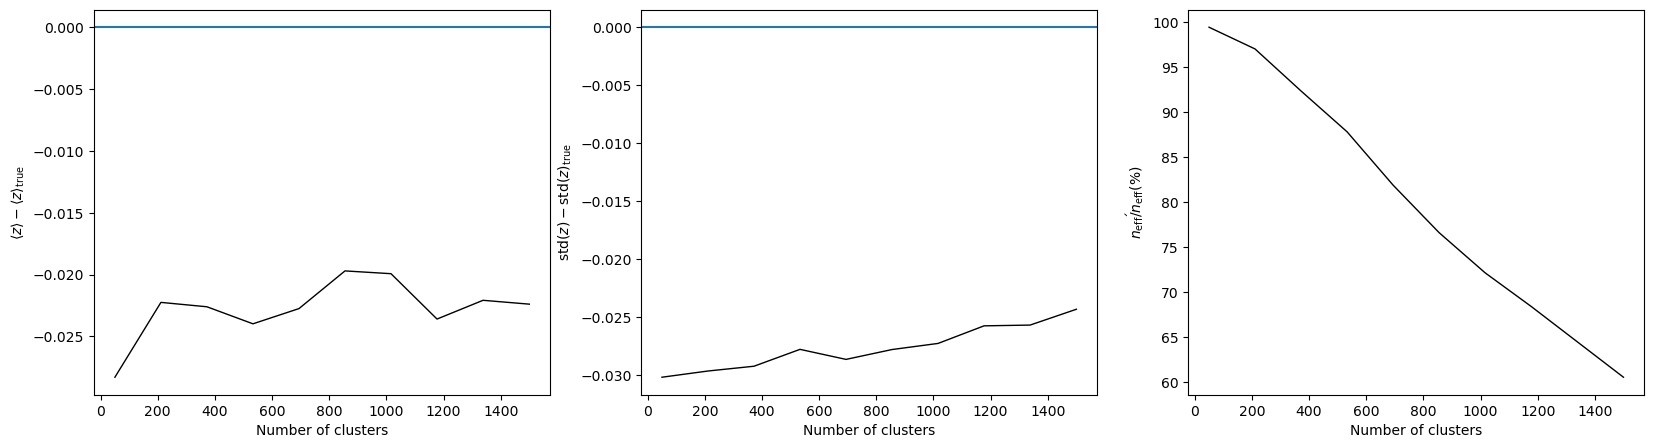

In [38]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

'''for i in range(25):
    axes[0].plot(n_clusterss, means_diff.T[i], lw=0.2, color='C1')'''
axes[0].plot(n_clusterss, mu_diff, lw=1, color='k')
axes[0].axhline(0,1,0)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel(r'$\left\langle z \right\rangle - \left\langle z \right\rangle_{\mathrm{true}}$')

'''for i in range(25):
    axes[1].plot(n_clusterss, std_diff.T[i], lw=0.2, color='C1')'''
axes[1].plot(n_clusterss, std_diff_mean, lw=1, color='k')
axes[1].axhline(0,1,0)

axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel(r'$\mathrm{std}(z) - \mathrm{std}(z)_{\mathrm{true}}$')


'''for i in range(25):
    axes[2].plot(n_clusterss, neff_p_to_neff.T[i]*100, lw=0.2, color='C1')'''
axes[2].plot(n_clusterss, neff_p_to_neff*100, lw=1, color='k')

axes[2].set_xlabel('Number of clusters')
axes[2].set_ylabel(r'$n_{\mathrm{eff}}\'/n_{\mathrm{eff}}$(%)')